In [1]:
import pandas as pd
import numpy as np

import os
print(os.getcwd())

/Users/vega7unk/Documents/4th Sem DSI/ilab project/ilab-group-12-1-fall-detection/notebooks


/Users/vega7unk/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
pd.set_option('display.max_columns', None)

df = pd.read_pickle("../data/df_filtered_cnn.pkl")

df.head()

,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,label
timestamp,,,,,,,
1970-01-01 00:38:38.700,0.209754,-2.331582,-0.203113,0.037081,0.031012,-0.012518,BSC
1970-01-01 00:38:38.800,0.203321,-2.349069,-0.194536,0.066225,0.079630,0.009396,BSC
1970-01-01 00:38:38.900,0.249716,-2.355785,-0.211275,0.196319,0.130287,0.033033,BSC
1970-01-01 00:38:39.000,0.276253,-2.345908,-0.201750,0.452604,0.035785,0.063763,BSC
1970-01-01 00:38:39.100,0.229522,-2.311028,-0.161954,0.682246,0.042157,0.127645,BSC


In [4]:
sensor_cols = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']

def create_windows(data, window_size=25, step_size=12):
    X, y = [], []
    data_array = data[sensor_cols].values
    labels = data['label'].values

    for start in range(0, len(data) - window_size + 1, step_size):
        end = start + window_size
        window_data = data_array[start:end]
        window_labels = labels[start:end]

        # Majority voting for label assignment
        unique, counts = np.unique(window_labels, return_counts=True)
        label = unique[np.argmax(counts)]

        X.append(window_data)
        y.append(label)

    return np.array(X), np.array(y)

X, y = create_windows(df)

In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.15, random_state=42)


In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout

# Define your input shape: e.g., (window_length, channels)
input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = len(set(y_train))  # 15 or 16 classes based on your labels

model_cnn_lstm = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    # The LSTM layer now interprets the feature maps temporally.
    LSTM(64, return_sequences=False),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model_cnn_lstm.compile(optimizer='adam',
                         loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'])

model_cnn_lstm.summary()


/Users/vega7unk/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 23, 64)         │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 21, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 8, 128)         │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         1,040 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,808 (507.06 KB)

 Trainable params: 129,808 (507.06 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model_cnn_lstm.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_test, y_test))

Epoch 1/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.7444 - loss: 0.8552 - val_accuracy: 0.8935 - val_loss: 0.2991
Epoch 2/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8900 - loss: 0.3094 - val_accuracy: 0.9131 - val_loss: 0.2254
Epoch 3/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9084 - loss: 0.2469 - val_accuracy: 0.9242 - val_loss: 0.1980
Epoch 4/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9176 - loss: 0.2161 - val_accuracy: 0.9182 - val_loss: 0.2040
Epoch 5/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9237 - loss: 0.1873 - val_accuracy: 0.9364 - val_loss: 0.1614
Epoch 6/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9273 - loss: 0.1711 - val_accuracy: 0.9318 - val_loss: 0.1791
Epoch 7/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9374 - loss: 0.1575 - val_accuracy: 0.9423 - val_loss: 0.1543
Epoch 8/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9400 - loss: 0.

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9667 - loss: 0.0856 - val_accuracy: 0.9565 - val_loss: 0.1590


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report, 
                             precision_score, recall_score, f1_score)

def evaluate_model(model, X_test, y_test, label_classes=None, plot_confusion_matrix=True, plot_roc=True):

    # Evaluate the model for loss and accuracy
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print("Test Loss: {:.4f}".format(loss))
    print("Test Accuracy: {:.4f}".format(accuracy))

    # Generate prediction probabilities and predicted classes
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    if plot_confusion_matrix:
        plt.figure(figsize=(10, 8))
        if label_classes is None:
            label_classes = [str(i) for i in range(cm.shape[0])]
        sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', 
                    xticklabels=label_classes, yticklabels=label_classes)
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.show()

    # Compute and print classification report
    report = classification_report(y_test, y_pred, target_names=label_classes)
    print("Classification Report:\n", report)

    # Compute weighted precision, recall, and F1 scores
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print("Weighted Precision: {:.4f}".format(precision))
    print("Weighted Recall: {:.4f}".format(recall))
    print("Weighted F1 Score: {:.4f}".format(f1))

    metrics = {
        'loss': loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

    return metrics

Test Loss: 0.1590
Test Accuracy: 0.9565
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


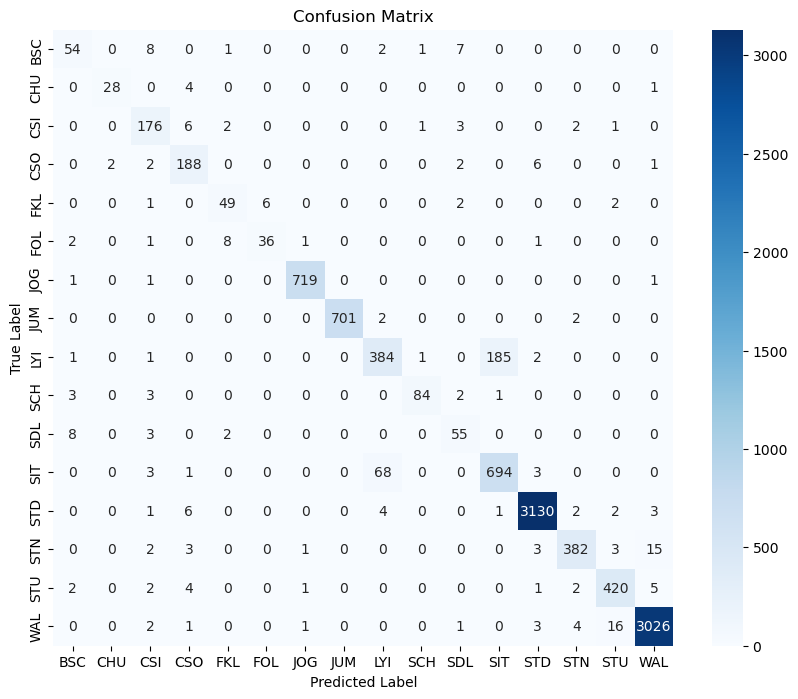

Classification Report:
               precision    recall  f1-score   support

         BSC       0.76      0.74      0.75        73
         CHU       0.93      0.85      0.89        33
         CSI       0.85      0.92      0.89       191
         CSO       0.88      0.94      0.91       201
         FKL       0.79      0.82      0.80        60
         FOL       0.86      0.73      0.79        49
         JOG       0.99      1.00      1.00       722
         JUM       1.00      0.99      1.00       705
         LYI       0.83      0.67      0.74       574
         SCH       0.97      0.90      0.93        93
         SDL       0.76      0.81      0.79        68
         SIT       0.79      0.90      0.84       769
         STD       0.99      0.99      0.99      3149
         STN       0.97      0.93      0.95       409
         STU       0.95      0.96      0.95       437
         WAL       0.99      0.99      0.99      3054

    accuracy                           0.96     10587
  

In [10]:
label_classes = [
    'BSC', 'CHU', 'CSI', 'CSO', 'FKL', 'FOL', 
    'JOG', 'JUM', 'LYI', 'SCH', 'SDL', 'SIT', 
    'STD', 'STN', 'STU', 'WAL'
]

metrics = evaluate_model(model_cnn_lstm, X_test, y_test, label_classes=label_classes)
